In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gurobipy as gp
from pandas import Series, DataFrame

#Bring the ROI data csv file
roi_data = pd.read_csv('ROI_data.csv')

In [2]:
roi_data

,Platform,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
0,ROI,0.031,0.049,0.024,0.039,0.016,0.024,0.046,0.026,0.033,0.044
1,Second Firms ROI Estimate,0.049,0.023,0.024,0.039,0.044,0.046,0.026,0.019,0.037,0.026


In [3]:
roi_data.iloc[[0]]

,Platform,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
0,ROI,0.031,0.049,0.024,0.039,0.016,0.024,0.046,0.026,0.033,0.044


In [4]:
roi_data.iloc[[1]]

,Platform,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
1,Second Firms ROI Estimate,0.049,0.023,0.024,0.039,0.044,0.046,0.026,0.019,0.037,0.026


## Part 1 (Q1-3)

Question:

Formulate the marketing budget allocation problem as a linear program. Use gurobi to find the
optimal budget allocation.

In [5]:
# define ROI list
roi_list_1 = [roi for roi in roi_data.iloc[0, 1:]]
roi_list_1

[0.031, 0.049, 0.024, 0.039, 0.016, 0.024, 0.046, 0.026, 0.033, 0.044]

#### **Formulating Marketing Budget Allocation Strategy**

To formulate an effective marketing budget allocation strategy, we consider the ideal investments in various marketing channels:

- Print (P): Investment in millions allocated to Print advertising.
- TV (TV): Investment in millions allocated to TV advertising.
- SEO (S): Investment in millions allocated to Search Engine Optimization.
- AdWords (A): Investment in millions allocated to AdWords advertising.
- Facebook (F): Investment in millions allocated to Facebook marketing.
- LinkedIn (L): Investment in millions allocated to LinkedIn advertising.
- Instagram (I): Investment in millions allocated to Instagram promotion.
- Snapchat (S): Investment in millions allocated to Snapchat advertising.
- Twitter (T): Investment in millions allocated to Twitter campaigns.
- Email (E): Investment in millions allocated to Email marketing.

By strategically allocating resources to these channels, we aim to optimize our marketing efforts and maximize returns on investment.

In [6]:
# create an empty gurobi model
budgetMod1=gp.Model()

# we first define each marketing medium as the variables
budgetX1 = budgetMod1.addMVar(10)

# define the objective using the decision variables
budgetMod1.setObjective(gp.quicksum(roi_list_1[i] * budgetX1[i] for i in range(10)), sense = gp.GRB.MAXIMIZE)

# Create a dictionary to match up with variable # and each marketing medium
mkt_medium_idx = {index: column for index, column in enumerate(roi_data.columns[1:])}
mkt_medium_idx

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-21


{0: 'Print',
 1: 'TV',
 2: 'SEO',
 3: 'AdWords',
 4: 'Facebook',
 5: 'LinkedIn',
 6: 'Instagram',
 7: 'Snapchat',
 8: 'Twitter',
 9: 'Email'}

In [7]:
conlist = [0]*4

# constraint a : Print + TV < Facebook + Email 
conlist[0] = budgetMod1.addConstr((budgetX1[0] + budgetX1[1]) <= (budgetX1[4] + budgetX1[9]))

# constraint b : Facebook + Linkedin + Instagram + Snapchat + Twitter >= 2(SEO + AdWords)
conlist[1] = budgetMod1.addConstr((budgetX1[4] + budgetX1[6] + budgetX1[5] + budgetX1[7] + budgetX1[8]) >= 2*(budgetX1[2] + budgetX1[3]))

# constraint c : each platform <= $3M 
conlist[2] = budgetMod1.addConstrs((budgetX1[i] <= 3 for i in range(10)))

# constraint d : sum of every platform <= $10M 
conlist[3] = budgetMod1.addConstr(gp.quicksum(budgetX1[i] for i in range(10)) <= 10)

In [8]:
budgetMod1.Params.OutputFlag = 0 

budgetMod1.optimize() # get the optimal budget allocation

In [9]:
budgetMod1.objVal

0.45600000000000007

In [10]:
budgetMod1.x 

[0.0, 3.0, 0.0, 1.0, 0.0, 0.0, 3.0, 0.0, 0.0, 3.0]

### Optimized Budget Allocation_1

In [11]:
allocation_1 = pd.DataFrame([budgetMod1.X], columns=roi_data.columns[1:])
allocation_1

,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
0,0.0,3.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,3.0


In [12]:
platform= roi_data.columns[1:]
alloc_1 = DataFrame()
alloc_1['Platform']  = platform
alloc_1['Allocation 1'] = budgetMod1.x 

alloc_1

,Platform,Allocation 1
0,Print,0.0
1,TV,3.0
2,SEO,0.0
3,AdWords,1.0
4,Facebook,0.0
5,LinkedIn,0.0
6,Instagram,3.0
7,Snapchat,0.0
8,Twitter,0.0
9,Email,3.0


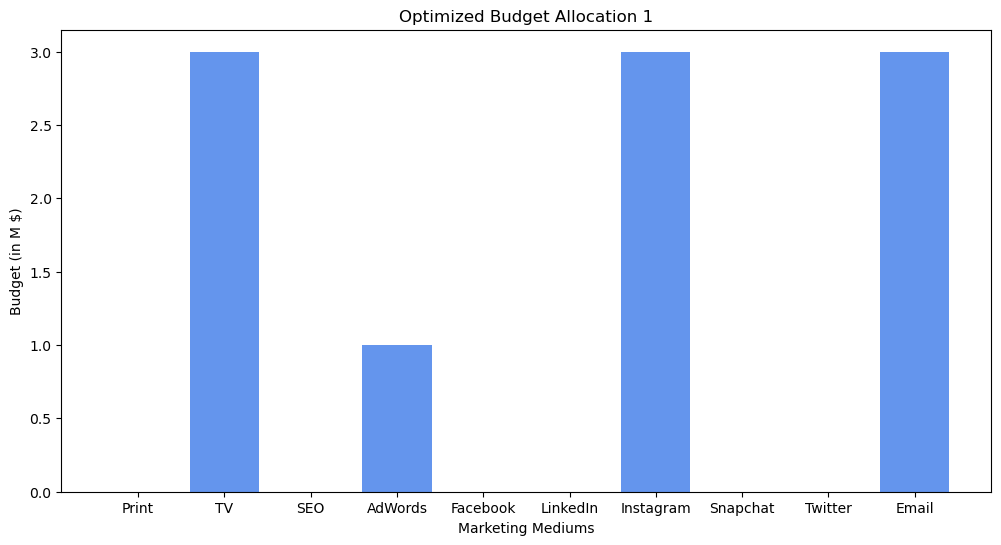

In [13]:
optimal_values = budgetMod1.x

variable_names = roi_data.columns[1:]

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(variable_names, optimal_values, color='cornflowerblue')
plt.xlabel('Marketing Mediums')
plt.ylabel('Budget (in M $)')
plt.title('Optimized Budget Allocation 1')
plt.show()

***Summary:***

This demonstrates that allocating an initial investment of 10 million in the following proportions: 0 (Print), 3 million (TV), 0 (SEO), 1 million (AdWords), 0 (Facebook), 0 (LinkedIn), 3 million (Instagram), 0 (Snapchat), 0 (Twitter), and 3 million (Email), results in a return on investment (ROI) of **0.456 million**, equivalent to a 4.56% ROI.

## Part 2 (Q4)

Question:

To be cautious about the decision, your team has decided to get another opinion about the ROI data and rerun the
analysis. The second consulting firm returns the estimates of the ROI data in the table below (also in the CSV file mentioned above). You are asked to compare the two optimal allocations from these two ROI estimates.

In [14]:
# define second ROI list
roi_list_2 = [roi for roi in roi_data.iloc[1, 1:]]
roi_list_2

[0.049, 0.023, 0.024, 0.039, 0.044, 0.046, 0.026, 0.019, 0.037, 0.026]

In [15]:
# create an empty gurobi model
budgetMod2=gp.Model()

# we first define each marketing medium as the variables
budgetX2 = budgetMod2.addMVar(10)

# define the objective using the decision variables
budgetMod2.setObjective(gp.quicksum(roi_list_2[i] * budgetX2[i] for i in range(10)), sense = gp.GRB.MAXIMIZE)

# Create a dictionary to match up with variable # and each marketing medium
mkt_medium_idx = {index: column for index, column in enumerate(roi_data.columns[1:])}
mkt_medium_idx

{0: 'Print',
 1: 'TV',
 2: 'SEO',
 3: 'AdWords',
 4: 'Facebook',
 5: 'LinkedIn',
 6: 'Instagram',
 7: 'Snapchat',
 8: 'Twitter',
 9: 'Email'}

In [16]:
conlist = [0]*4

# constraint a : Print + TV < Facebook + Email 
conlist[0] = budgetMod2.addConstr((budgetX2[0] + budgetX2[1]) <= (budgetX2[4] + budgetX2[9]))

# constraint b : Facebook + Linkedin + Instagram + Snapchat + Twitter >= 2(SEO + AdWords)
conlist[1] = budgetMod2.addConstr((budgetX2[4] + budgetX2[6] + budgetX2[5] + budgetX2[7] + budgetX2[8]) >= 2*(budgetX2[2] + budgetX2[3]))

# constraint c : each platform <= $3M 
conlist[2] = budgetMod2.addConstrs((budgetX2[i] <= 3 for i in range(10)))

# constraint d : sum of every platform <= $10M 
conlist[3] = budgetMod2.addConstr(gp.quicksum(budgetX2[i] for i in range(10)) <= 10)

In [17]:
budgetMod2.Params.OutputFlag = 0 

budgetMod2.optimize() # get the optimal budget allocation

In [18]:
budgetMod2.objVal

0.45600000000000007

In [19]:
budgetMod2.X

[3.0, 0.0, 0.0, 1.0, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0]

### Optimized budget allocation_2

In [20]:
allocation_2 = pd.DataFrame([budgetMod2.X], columns=roi_data.columns[1:])
allocation_2

,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
0,3.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0


In [21]:
alloc_2 = DataFrame()
alloc_2['Platform']  = platform
alloc_2['Allocation 2'] = budgetMod2.x 
alloc_2

,Platform,Allocation 2
0,Print,3.0
1,TV,0.0
2,SEO,0.0
3,AdWords,1.0
4,Facebook,3.0
5,LinkedIn,3.0
6,Instagram,0.0
7,Snapchat,0.0
8,Twitter,0.0
9,Email,0.0


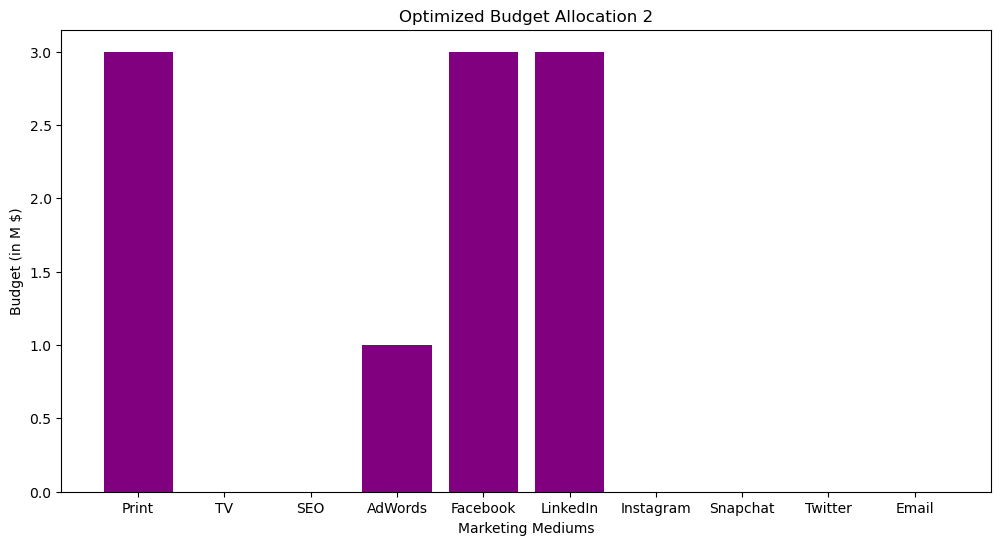

In [22]:
optimal_values_2 = budgetMod2.x

variable_names = roi_data.columns[1:]

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(variable_names, optimal_values_2, color='purple')
plt.xlabel('Marketing Mediums')
plt.ylabel('Budget (in M $)')
plt.title('Optimized Budget Allocation 2')
plt.show()

***Summary:***

This illustrates that an initial investment of 10 million, allocated as follows: 3 million (Print), 0 (TV), 0 (SEO), 1 million (AdWords), 3 million (Facebook), 3 million (LinkedIn), 0 (Instagram), 0 (Snapchat), 0 (Twitter), and 0 (Email), results in an ROI of **0.456 million**, equivalent to a 4.56% return on investment.

## Part 3 (Q5)

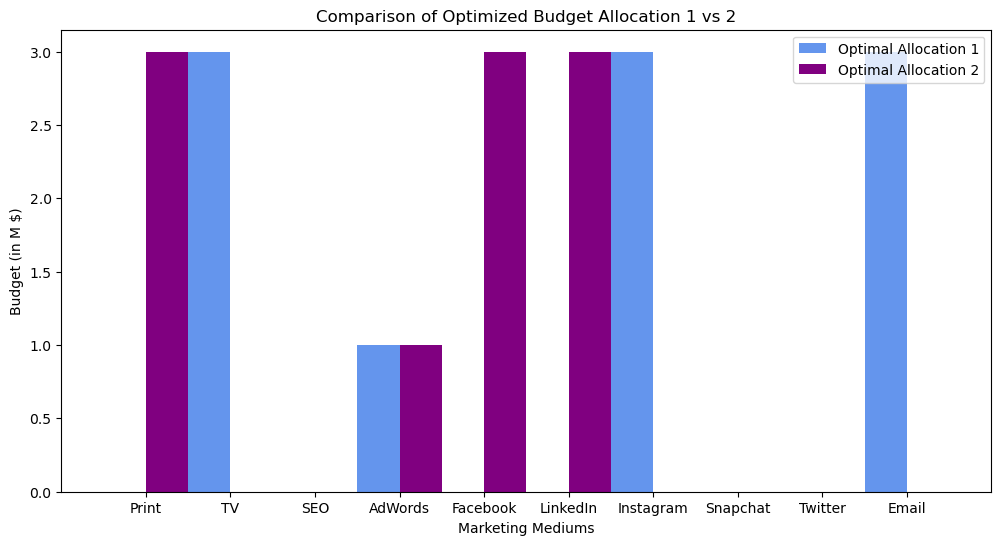

In [23]:
optimal_values_1 = budgetMod1.x 
optimal_values_2 = budgetMod2.x

# Setting the positions and width for the bars
pos = np.arange(len(variable_names))
bar_width = 0.5

# Create the bar chart
plt.figure(figsize=(12, 6))

# Plot the bars for the first set of data
plt.bar(pos - bar_width/2, optimal_values_1, bar_width, label='Optimal Allocation 1', color='cornflowerblue')

# Plot the bars for the second set of data
plt.bar(pos + bar_width/2, optimal_values_2, bar_width, label='Optimal Allocation 2', color='purple')

# Add some text for labels, title, and axes ticks
plt.xlabel('Marketing Mediums')
plt.ylabel('Budget (in M $)')
plt.title('Comparison of Optimized Budget Allocation 1 vs 2')

# Label the x-axis with the variable names
plt.xticks(pos, variable_names)

# Add a legend to explain which bars are which
plt.legend()

# Show the plot
plt.show()

#### Are the allocations the same?

There is a slight difference in allocation, but the optimal objective remains the same.

#### Assuming the first ROI data is correct, if you were to use the second allocation (the allocation that assumed the second ROI data was correct) how much lower would the objective be relative to the optimal objective (the one that uses the first ROI data and the first allocation)?

In [24]:
# simulate first ROI * second budget allocation
first_second = roi_data.iloc[0, 1:] * allocation_2
first_second

,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
0,0.093,0.0,0.0,0.039,0.048,0.072,0.0,0.0,0.0,0.0


In [25]:
# optimal objective by first ROI * first allocation
first_first = budgetMod1.objVal

print('Second Allocation in First ROI:', sum(first_second.iloc[0]))

# get the difference between the optimal objective and the first ROI * second allocation
print('Difference:', first_first - sum(first_second.iloc[0]))

Second Allocation in First ROI: 0.252
Difference: 0.20400000000000007


***Summary:***

Thus, utilizing the allocation from the second ROI objective in the first ROI objective function leads to total ROI being **$0.204M lower**, which is a 45% reduction in return

#### Assuming the second ROI data is correct, if you used the first allocation how much lower would the objective be relative to the optimal objective?

In [26]:
# simulate second ROI * first budget allocation
second_first = roi_data.iloc[1, 1:] * allocation_1
second_first

,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
0,0.0,0.069,0.0,0.039,0.0,0.0,0.078,0.0,0.0,0.078


In [27]:
# optimal objective by first ROI * first allocation
second_second = budgetMod2.objVal

print('First Allocation in Second ROI:', sum(second_first.iloc[0]))

# get the difference between the optimal objective and the first ROI * second allocation
print('Difference:', second_second - sum(second_first.iloc[0]))

First Allocation in Second ROI: 0.264
Difference: 0.19200000000000006


***Summary:***

Thus, utilizing the allocation from the first ROI objective in the seocnd ROI objective function leads to total ROI being ***$0.192M lower***, which is a 42% reduction in returns

#### Do you think the third constraint above, based on your boss’ experience, is useful?

#### Removing the third constraint related to investment limit of 3 million in each platform - Using ROI Function 1

In [28]:
# when removing the third constraint
roi_list_3 = [roi for roi in roi_data.iloc[0, 1:]]
roi_list_3

# create an empty gurobi model
budgetMod3=gp.Model()

# we first define each marketing medium as the variables
budgetX3 = budgetMod3.addMVar(10)

# define the objective using the decision variables
budgetMod3.setObjective(gp.quicksum(roi_list_3[i] * budgetX3[i] for i in range(10)), sense = gp.GRB.MAXIMIZE)

# Create a dictionary to match up with variable # and each marketing medium
mkt_medium_idx = {index: column for index, column in enumerate(roi_data.columns[1:])}
mkt_medium_idx

conlist = [0]*3

# constraint a : Print + TV < Facebook + Email 
conlist[0] = budgetMod3.addConstr((budgetX3[0] + budgetX3[1]) <= (budgetX3[4] + budgetX3[9]))

# constraint b : Facebook + Linkedin + Instagram + Snapchat + Twitter >= 2(SEO + AdWords)
conlist[1] = budgetMod3.addConstr((budgetX3[4] + budgetX3[6] + budgetX3[5] + budgetX3[7] + budgetX3[8]) >= 2*(budgetX3[2] + budgetX3[3]))

# constraint c : sum of every platform <= $10M 
conlist[2] = budgetMod3.addConstr(gp.quicksum(budgetX3[i] for i in range(10)) <= 10000000)

budgetMod3.Params.OutputFlag = 0 

budgetMod3.optimize() # get the optimal budget allocation

print('Objective Value: ',budgetMod3.objVal)

print('Allocation:',budgetMod3.x)

Objective Value:  465000.0
Allocation: [0.0, 5000000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5000000.0]


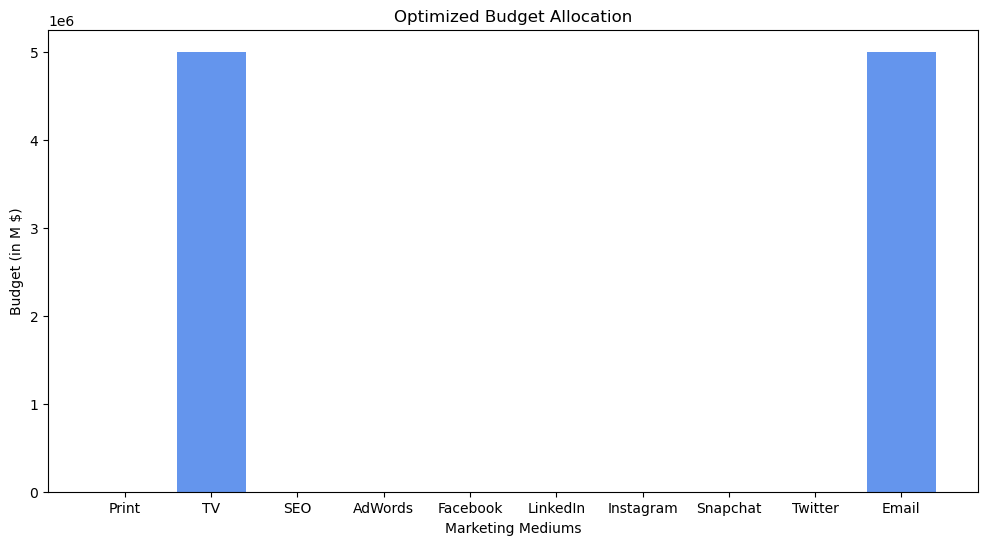

In [29]:
optimal_values3 = budgetMod3.x

variable_names = roi_data.columns[1:]

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(variable_names, optimal_values3,color='cornflowerblue')
plt.xlabel('Marketing Mediums')
plt.ylabel('Budget (in M $)')
plt.title('Optimized Budget Allocation')
plt.show()

***Summary:***

Impact on ROI using Data 1: 

By removing the third constraint, the objective ROI increases to **0.465 million** from its previous value of 0.456 million, representing an approximately 2% improvement. However, this change results in a less diversified investment allocation, concentrating the funds on only two platforms: TV and Email. This concentration increases the risk associated with the investment.

In essence, the third constraint serves as a risk management measure by ensuring portfolio diversification. Therefore, it is advisable to retain this constraint, especially considering that a 2% increase in overall ROI may not justify the additional risk it introduces.

#### Removing the third constraint related to investment limit of 3 million in each platform - Using ROI Function 2

In [30]:
# when removing the third constraint
roi_list_4 = [roi for roi in roi_data.iloc[1, 1:]]
roi_list_4

# create an empty gurobi model
budgetMod4=gp.Model()

# we first define each marketing medium as the variables
budgetX4 = budgetMod4.addMVar(10)

# define the objective using the decision variables
budgetMod4.setObjective(gp.quicksum(roi_list_4[i] * budgetX4[i] for i in range(10)), sense = gp.GRB.MAXIMIZE)

# Create a dictionary to match up with variable # and each marketing medium
mkt_medium_idx = {index: column for index, column in enumerate(roi_data.columns[1:])}
mkt_medium_idx

conlist = [0]*3

# constraint a : Print + TV < Facebook + Email 
conlist[0] = budgetMod4.addConstr((budgetX4[0] + budgetX4[1]) <= (budgetX4[4] + budgetX4[9]))

# constraint b : Facebook + Linkedin + Instagram + Snapchat + Twitter >= 2(SEO + AdWords)
conlist[1] = budgetMod4.addConstr((budgetX4[4] + budgetX4[6] + budgetX4[5] + budgetX4[7] + budgetX4[8]) >= 2*(budgetX4[2] + budgetX4[3]))

# constraint c : sum of every platform <= $10M 
conlist[2] = budgetMod4.addConstr(gp.quicksum(budgetX4[i] for i in range(10)) <= 10000000)

budgetMod4.Params.OutputFlag = 0 

budgetMod4.optimize() # get the optimal budget allocation

print('Objective Value: ',budgetMod4.objVal)

print('Allocation:',budgetMod4.x)

Objective Value:  465000.0
Allocation: [5000000.0, 0.0, 0.0, 0.0, 5000000.0, 0.0, 0.0, 0.0, 0.0, 0.0]


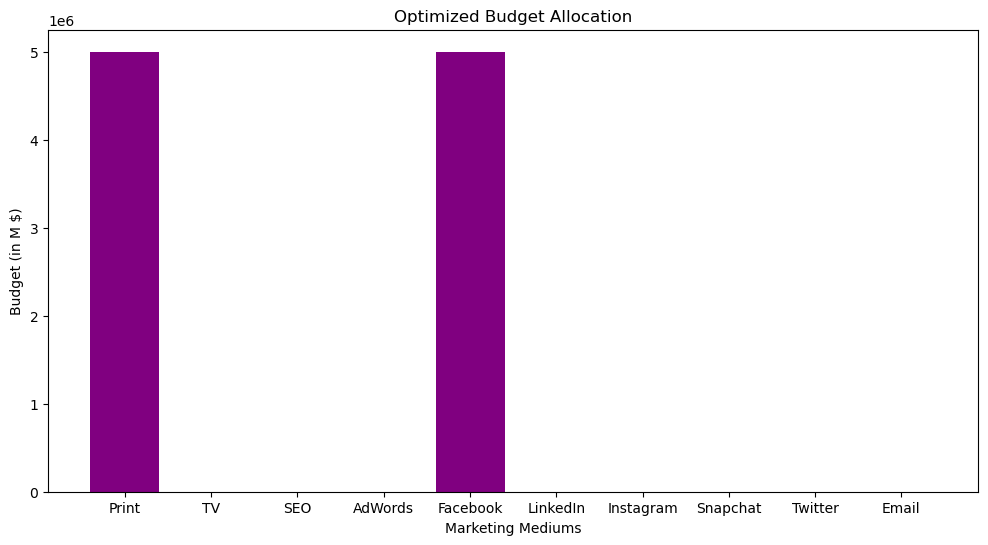

In [31]:
optimal_values4 = budgetMod4.x

variable_names = roi_data.columns[1:]

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(variable_names, optimal_values4, color='purple')
plt.xlabel('Marketing Mediums')
plt.ylabel('Budget (in M $)')
plt.title('Optimized Budget Allocation')
plt.show()

***Summary:***

Impact on ROI using Data 2: 

By removing the third constraint, the objective ROI increases to **0.465 million** from its previous value of 0.456 million, representing an approximately 2% improvement. However, this change results in a less diversified investment allocation, concentrating the funds on only two platforms: Print and Facebook. This concentration increases the risk associated with the investment.

In essence, the third constraint serves as a risk management measure by ensuring portfolio diversification. Therefore, it is advisable to retain this constraint, especially considering that a 2% increase in overall ROI may not justify the additional risk it introduces.

***Conclusion:***

The relatively minor variations in the objective function, specifically a decrease of \\$204,000 and \\$192,000 when different ROI datasets are utilized, may suggest either a stable market environment or a high risk tolerance within the company's strategy. In such scenarios, the third constraint, which imposes a \\$3 million budget limit per platform, might be perceived as conservative. Notably, considering that the optimized objective under this constraint is \\$456,000 compared to the maximum achievable objective of \\$465,000 without the constraint, it's evident that this constraint restricts the potential return on investment.

Nevertheless, constraints serve a dual purpose, not only focusing on maximizing returns but also addressing risk management. The third constraint ensures that the budget allocation is diversified across multiple platforms (4 out of 10) rather than being concentrated in just two. This diversification acts as an additional layer of risk mitigation, safeguarding the company against excessive concentration in one or two platforms, which could be precarious in a volatile or uncertain market. Therefore, while the constraint does limit the potential ROI, the advantages it offers in terms of risk mitigation and diversification could justify its inclusion in the optimization model. Ultimately, it's a trade-off between maximizing returns and prudently managing risk.







## Part 4 (Q6)

Question:

Perform some analysis of how your optimal allocation would change
based on changes in the ROI data. Use the first ROI data as your starting point. By how much
could each advertising medium’s ROI increase or decrease and still result in the same optimal
allocation you found in step (3)

In [32]:
# use first ROI data as a starting point
roi_list_1

[0.031, 0.049, 0.024, 0.039, 0.016, 0.024, 0.046, 0.026, 0.033, 0.044]

In [33]:
# Upper bound of the first ROI that result in the same optimal allocation
budgetX1.SAObjUp

array([0.049, 0.062, 0.039, 0.046, 0.029, 0.039,   inf, 0.039, 0.039,
         inf])

In [34]:
# Lower bound of the first ROI that result in the same optimal allocation
budgetX1.SAObjLow

array([ -inf, 0.039,  -inf, 0.033,  -inf,  -inf, 0.039,  -inf,  -inf,
       0.029])

In [35]:
# Possible amount of ROI increase
budgetX1.SAObjUp - roi_list_1

array([0.018, 0.013, 0.015, 0.007, 0.013, 0.015,   inf, 0.013, 0.006,
         inf])

In [36]:
# Possible amount of ROI decrease
roi_list_1 - budgetX1.SAObjLow

array([  inf, 0.01 ,   inf, 0.006,   inf,   inf, 0.007,   inf,   inf,
       0.015])

In [37]:
# Create a dictionary
roi_range = {'starting_ROI': roi_list_1, 'LowerBound': budgetX1.SAObjLow,'UpperBound': budgetX1.SAObjUp, 'possible_Increase_amt': budgetX1.SAObjUp - roi_list_1, 'Possible_Decrease_amt': roi_list_1 - budgetX1.SAObjLow}

# Create a DataFrame
roi_ranges = pd.DataFrame(roi_range)

# Change the index name
roi_ranges.index = roi_data.columns[1:]

roi_ranges

,starting_ROI,LowerBound,UpperBound,possible_Increase_amt,Possible_Decrease_amt
Print,0.031,-inf,0.049,0.018,inf
TV,0.049,0.039,0.062,0.013,0.010
SEO,0.024,-inf,0.039,0.015,inf
AdWords,0.039,0.033,0.046,0.007,0.006
Facebook,0.016,-inf,0.029,0.013,inf
LinkedIn,0.024,-inf,0.039,0.015,inf
Instagram,0.046,0.039,inf,inf,0.007
Snapchat,0.026,-inf,0.039,0.013,inf
Twitter,0.033,-inf,0.039,0.006,inf
Email,0.044,0.029,inf,inf,0.015


***Individual Interpretation:***

- Print: Beginning with an ROI of about 0.031, Print's allocation demonstrates a high tolerance for decreases in ROI, as there's no discernible lower limit. However, the existence of a definite upper bound implies that it is sensitive to substantial ROI increases. Its sensitivity to ROI increases suggests there's untapped potential in the Print medium. If Print starts delivering better results, the optimal strategy might shift more budget towards it. On the other hand, its high tolerance for ROI decreases means that even if Print underperforms, it remains a valuable part of the marketing mix, possibly due to its reach or branding impact.


- TV: starting at 0.049, TV's ROI can vary between 0.039 to 0.062. This relatively narrow range suggests TV's allocation is moderately stable to ROI shifts. Its moderately stable range indicates that TV is already being leveraged well. Significant shifts in its performance, whether positive or negative, might not drastically change its allocation, suggesting its foundational role in the advertising strategy.


- SEO: With a starting ROI of 0.024, SEO's upward adjustment potential is limited to just 0.015. This narrow range suggests that SEO's allocation is susceptible to positive ROI shifts, where even modest enhancements could alter its optimal allocation. SEO's sensitivity to positive ROI shifts implies that any performance improvements could lead to larger budget allocations. It's an area with potential growth opportunities, but its current ROI might not have fully justified a heftier investment.


- AdWords: AdWords begins with an ROI of 0.039 and can fluctuate between 0.033 and 0.046, implying that its allocation might be affected by both positive and negative ROI shifts, but within a tight range. The tight range suggests that AdWords is a high-maintenance platform. Small changes in its performance can affect its budget allocation, indicating the need for constant monitoring.


- Facebook: Starting with an ROI of 0.016, Facebook has no set lower boundary but can endure an increase up to 0.029, suggesting it's more sensitive to ROI decreases but has some space for positive shifts. The platform's sensitivity to ROI decreases and some room for positive shifts suggests it's a medium in transition. It's essential to keep an eye on its performance, as its allocation can shift based on its ROI trajectory.


- Instagram: With a strong starting ROI of 0.046 and a lower limit of 0.039, Instagram's allocation can tolerate some decreases in ROI. Its lack of an upper boundary indicates it has vast potential for positive ROI changes. Instagram's resilience against decreases and unlimited potential for positive ROI changes makes it a cornerstone of the advertising strategy. It's a platform with both stability and growth potential.


- Email: Beginning with an ROI of 0.044, Email has an established lower boundary at 0.029 but offers unlimited growth potential, indicating its allocation is stable against ROI decreases and highly adaptive to positive changes. Email's stability against ROI decreases combined with its high growth potential suggests it's a reliable and promising platform. Its consistent performance and potential for better results make it a prime candidate for future investments.

In [38]:
obj_low_and_up = pd.DataFrame()
obj_low_and_up['channel'] = ['Print', 'TV', 'SEO', 'AdWords', 'Facebook', 'LinkedIn',
       'Instagram', 'Snapchat', 'Twitter', 'Email']
obj_low_and_up['lower'] = list(budgetX1.SAObjLow)
obj_low_and_up['upper'] = list(budgetX1.SAObjUp)
obj_low_and_up

,channel,lower,upper
0,Print,-inf,0.049
1,TV,0.039,0.062
2,SEO,-inf,0.039
3,AdWords,0.033,0.046
4,Facebook,-inf,0.029
5,LinkedIn,-inf,0.039
6,Instagram,0.039,inf
7,Snapchat,-inf,0.039
8,Twitter,-inf,0.039
9,Email,0.029,inf


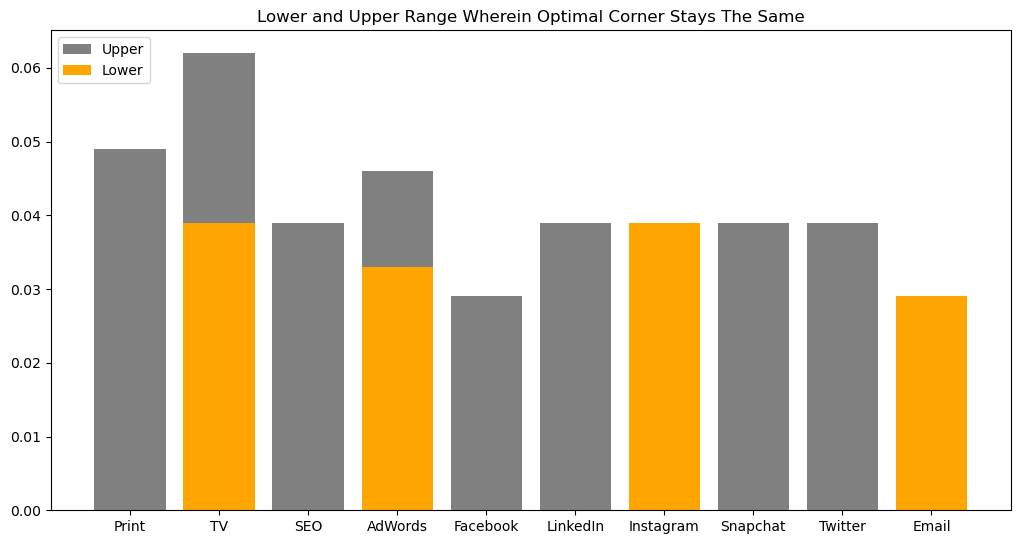

In [39]:
import matplotlib.pyplot as plt

fig3 = plt.figure()
ax = fig3.add_axes([0,0,1.5,1])
channels_3 = ['Print', 'TV', 'SEO', 'AdWords', 'Facebook', 'LinkedIn',
       'Instagram', 'Snapchat', 'Twitter', 'Email']
allocations_3 = budgetX1.SAObjUp
allocations_4 = budgetX1.SAObjLow
ax.bar(channels_3,allocations_3, label = "Upper", color='gray')
ax.bar(channels_3, allocations_4, label = "Lower", color='orange')
ax.set_title("Lower and Upper Range Wherein Optimal Corner Stays The Same")
plt.legend()
plt.show()

#### Overall Interpretation:

***Stability and Risk:*** 
For mediums where the 'decrease' and 'increase' values are low, the optimal allocation is sensitive to changes in ROI. For those with higher 'decrease' and 'increase' values, the allocation is relatively stable or less sensitive to changes in ROI. Media like TV, Instagram, and Email offer stable and less risky investments due to their high 'increase' and 'decrease' values.


***Upside Potential:*** 
Media with a high 'increase' value have more room for upside in ROI without affecting the optimal allocation. Conversely, a low 'decrease' value indicates less room for downside. Platforms like Instagram and Email have significant upside potential, making them excellent choices for aggressive growth strategies.


***Diversification:*** 
If all mediums have low 'decrease' and 'increase' values, it suggests that diversification is beneficial. If one medium's ROI drops, you might want to allocate more to another medium. Given the varying sensitivities to ROI changes across mediums (e.g., Print, SEO, Facebook), diversifying the marketing budget can mitigate risks.


***Volatile Investments:***
If either 'decrease' or 'increase' is zero, it indicates that any change in ROI would result in a different optimal allocation, making those mediums risky or volatile investment channels.
AdWords and Twitter are highly sensitive to ROI changes, requiring close monitoring and potentially making them risky investments.


***Decision-Making:*** 
For practical purposes, if a medium has both a high 'decrease' and a high 'increase', it might be considered 'safe' to invest in, as your optimal allocation doesn't change much with fluctuations in ROI. Platforms like TV and Instagram seem 'safe' to invest in due to high stability in ROI, while SEO and LinkedIn might require more cautious approaches


***Absolute ROI Values*** 
Mediums with higher current ROI values are generally prioritized more in budget allocation. However, this should be looked at in conjunction with how much those ROIs can fluctuate ('increase' and 'decrease').

## Part 5 (Q7)

Question:

Your boss has gained permission to reinvest half of the return. For example, if the marketing
obtains a 4% return in January, the budget of February will be \\$10M + \\$10M × 4% × 50% =
$10.2M. The monthly ROI for next year is given in an attached csv file. The three constraints
given by your boss are still in place for each month. What is the optimal allocation for each
month?

In [40]:
# Load the ROI data from a CSV file into a DataFrame
roi_mat = pd.read_csv('roi_mat.csv')

# Rename the 'Unnamed: 0' column to 'Months' for clarity
roi_mat.rename(columns={"Unnamed: 0": "Months"}, inplace=True)


In [41]:
roi_mat

,Months,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
0,January,4.0,3.6,2.4,3.9,3.0,3.5,3.6,2.25,3.5,3.5
1,February,4.0,3.9,2.7,3.8,4.3,3.2,2.7,1.80,3.7,3.5
2,March,3.5,2.9,3.1,3.8,2.4,4.1,3.7,2.60,4.2,2.5
3,April,3.8,3.1,2.4,4.4,2.4,3.8,3.7,2.50,3.6,2.9
4,May,3.5,3.2,1.9,3.4,2.7,2.7,3.9,2.20,4.5,3.9
5,June,4.0,3.2,2.7,3.4,3.4,3.0,4.5,2.10,3.8,4.1
6,July,3.9,3.6,2.0,4.4,3.9,3.7,4.3,1.80,4.0,3.8
7,August,4.2,3.3,2.8,4.2,2.0,3.7,3.6,1.50,4.4,4.3
8,September,4.1,2.8,2.5,4.2,2.9,3.7,2.8,2.50,4.0,3.4
9,October,3.0,3.0,3.1,4.6,3.1,3.3,3.2,2.30,2.5,3.2


In [42]:
# Storing the column names
col_names=roi_data.columns
# Keeping only the different mediums
col_names=col_names[1:]

In [43]:
col_names

Index(['Print', 'TV', 'SEO', 'AdWords', 'Facebook', 'LinkedIn', 'Instagram',
       'Snapchat', 'Twitter', 'Email'],
      dtype='object')

In [44]:
# Set the initial value for 'obmax' to 10
obmax_initial = 10

# Create an empty list to store results
result_list = []

# Iterate through rows in the 'roi_mat' DataFrame
for index, row in roi_mat[:].iterrows():
    
    # Create a new optimization model
    model = gp.Model()
    
    # Add a decision variable 'Adx' with a shape of (1, 10) and an upper bound of 3
    Adx = model.addMVar((1, 10), ub=3) 
    
    # Convert row values to a numpy array and scale them by dividing each element by 100
    scaled_row = np.array([val / 100 for val in list(row[1:])], dtype='float32')
   
    # Add constraints
    cons_1 = model.addConstr(Adx[0, 0] + Adx[0, 1] <= Adx[0, 4] + Adx[0, 9])
    cons_2 = model.addConstr(Adx[0, 4] + Adx[0, 5] + Adx[0, 6] + Adx[0, 7] + Adx[0, 8] >= 2 * (Adx[0, 2] + Adx[0, 3]))
    cons_3 = model.addConstr(gp.quicksum(Adx[0, j] for j in range(10)) <= obmax_initial)
    
    # Set the objective function
    model.setObjective(gp.quicksum(scaled_row[j] * Adx[0, j] for j in range(10)), gp.GRB.MAXIMIZE)
    
    # Suppress solver output
    model.Params.OutputFlag = 0 
    
    # Optimize the model
    model.optimize()

    # Get the optimized objective value
    objective_value = model.objVal
    
    # Calculate 'ret' by dividing the objective value by 'obmax_initial'
    ret = objective_value / obmax_initial
    
    # Update 'obmax' based on the calculated 'ret'
    obmax_initial = 10 + (ret * 0.5) * 10
    
    # Append the solution to the result list
    result_list.append(model.x)

# Create a DataFrame 'df_monthly' from the results with appropriate columns and index
df_monthly = pd.DataFrame(data=result_list, columns=col_names, index=roi_mat['Months'])

***Optimal Allocation for each Month is shown below:***

In [45]:
# Set the display format for float values
pd.options.display.float_format = '{:.2f}'.format
df_monthly

,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
Months,,,,,,,,,,
January,3.00,0.00,0.00,1.33,0.00,0.00,2.67,0.00,0.00,3.00
February,3.00,0.00,0.00,2.40,3.00,0.00,0.00,0.00,1.79,0.00
March,0.00,0.00,0.00,3.00,0.00,3.00,1.20,0.00,3.00,0.00
April,0.00,0.00,0.00,3.00,0.00,3.00,3.00,0.00,1.20,0.00
May,1.20,0.00,0.00,0.00,0.00,0.00,3.00,0.00,3.00,3.00
June,3.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,1.20,3.00
July,0.00,0.00,0.00,3.00,1.21,0.00,3.00,0.00,3.00,0.00
August,2.71,0.00,0.00,1.50,0.00,0.00,0.00,0.00,3.00,3.00
September,0.61,0.00,0.00,3.00,0.00,3.00,0.00,0.00,3.00,0.61


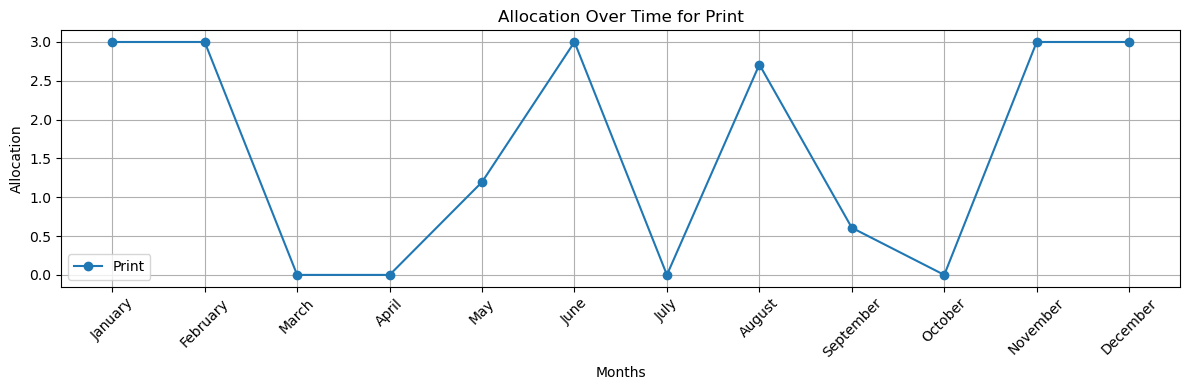

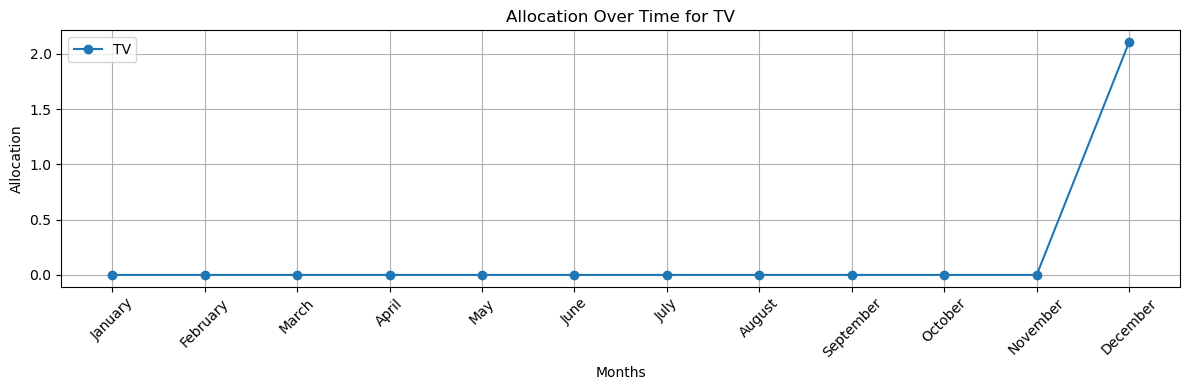

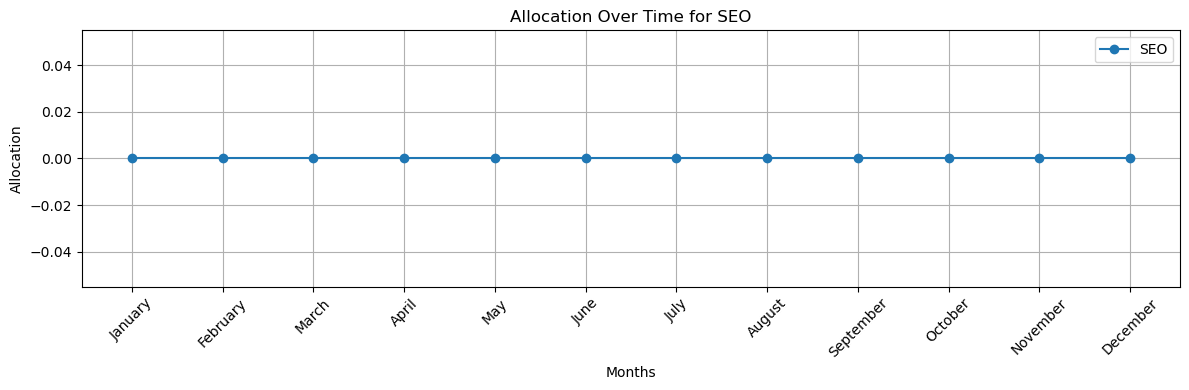

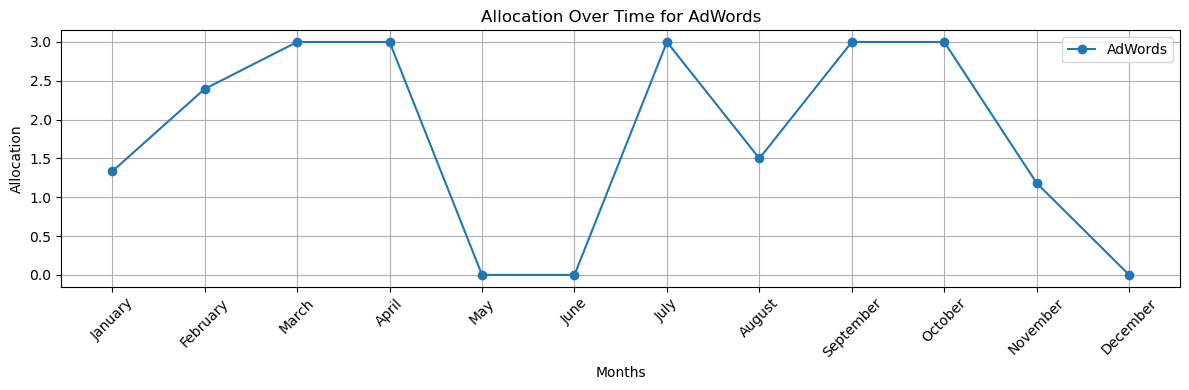

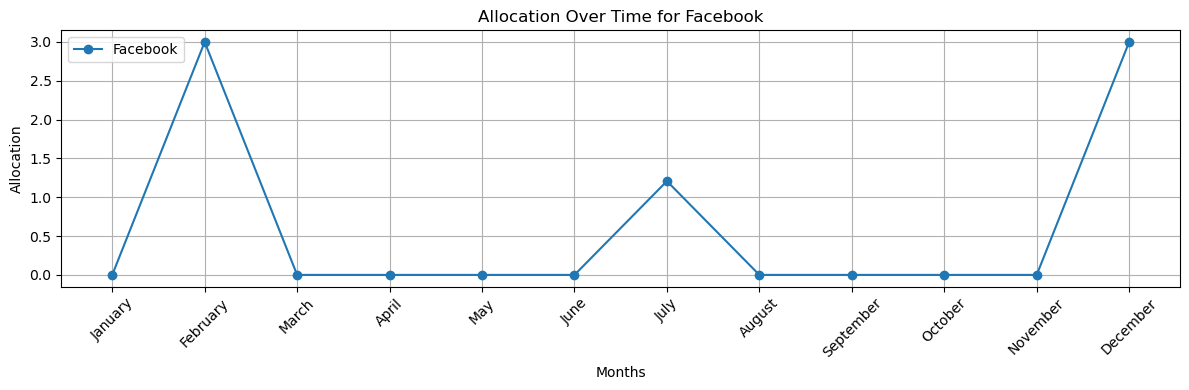

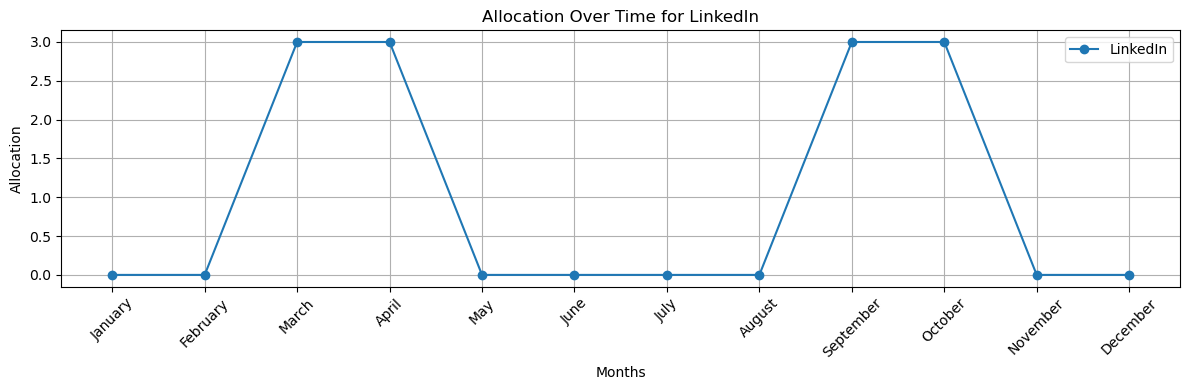

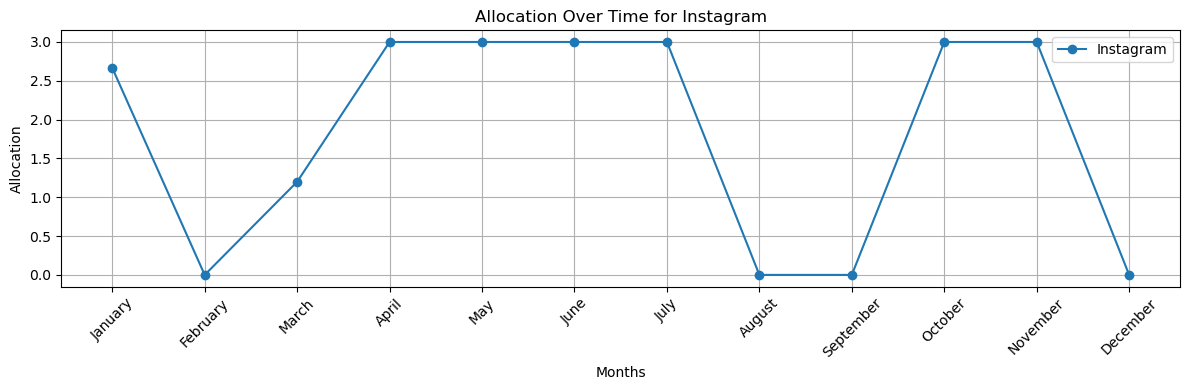

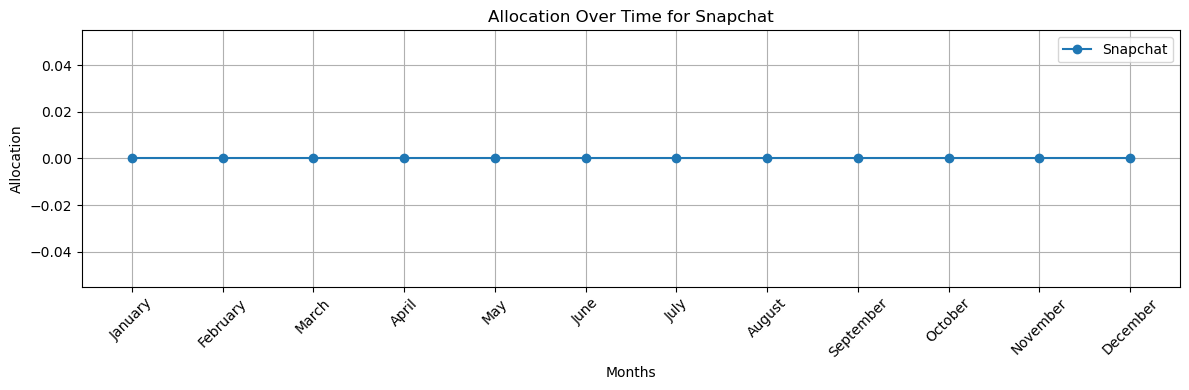

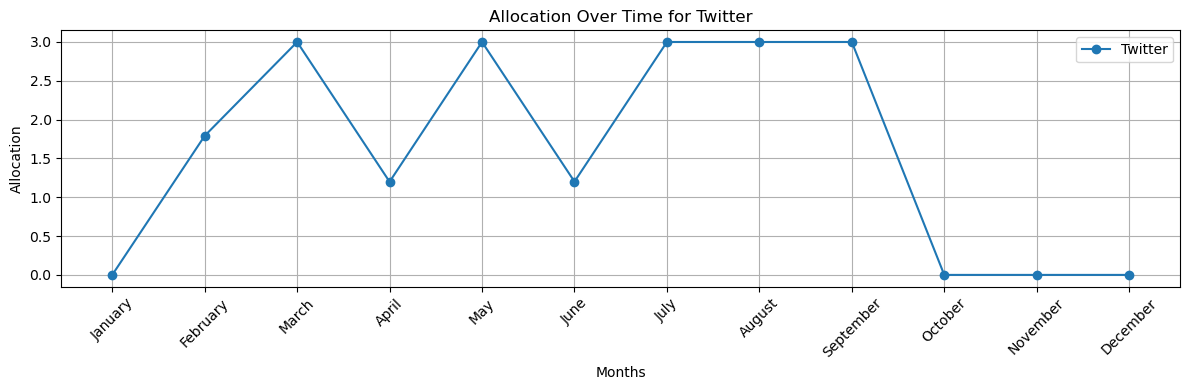

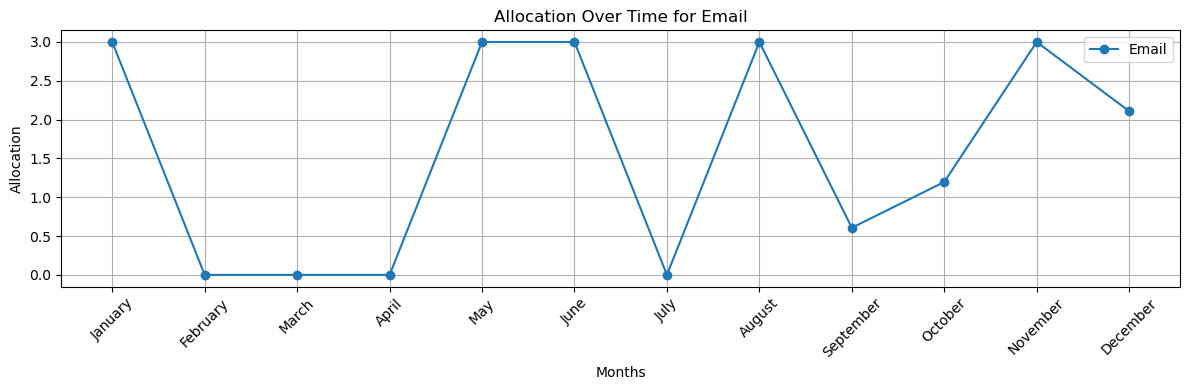

In [46]:
# Create separate line charts for each allocation component
for col in df_monthly.columns:
    plt.figure(figsize=(12, 4))
    plt.plot(df_monthly.index, df_monthly[col], label=col, marker='o')
    
    plt.title(f"Allocation Over Time for {col}")
    plt.xlabel("Months")
    plt.ylabel("Allocation")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()

plt.show()  # Display all charts together (comment this line if you saved individual charts)

## Part 6 (Q8)

Question:

A stable budget is defined as a monthly allocation such that for each platform the monthly
change in spend is no more than $1M. Is the allocation you found stable? If it isn’t, you do not
need to solve a new optimization model. Describe how my might model this?

In [47]:
# Import the 'copy' module to create a deep copy of a DataFrame
import copy 

# Create a deep copy of the 'df_monthly' DataFrame
df_monthly_change = copy.deepcopy(df_monthly)

# Calculate the difference between consecutive rows in the DataFrame
df_monthly_change = df_monthly_change.diff()

# Display the resulting DataFrame containing the differences
df_monthly_change

,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
Months,,,,,,,,,,
January,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
February,0.00,0.00,0.00,1.06,3.00,0.00,-2.67,0.00,1.79,-3.00
March,-3.00,0.00,0.00,0.60,-3.00,3.00,1.20,0.00,1.21,0.00
April,0.00,0.00,0.00,0.00,0.00,0.00,1.80,0.00,-1.80,0.00
May,1.20,0.00,0.00,-3.00,0.00,-3.00,0.00,0.00,1.80,3.00
June,1.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.80,0.00
July,-3.00,0.00,0.00,3.00,1.21,0.00,0.00,0.00,1.80,-3.00
August,2.71,0.00,0.00,-1.50,-1.21,0.00,-3.00,0.00,0.00,3.00
September,-2.10,0.00,0.00,1.50,0.00,3.00,0.00,0.00,0.00,-2.39


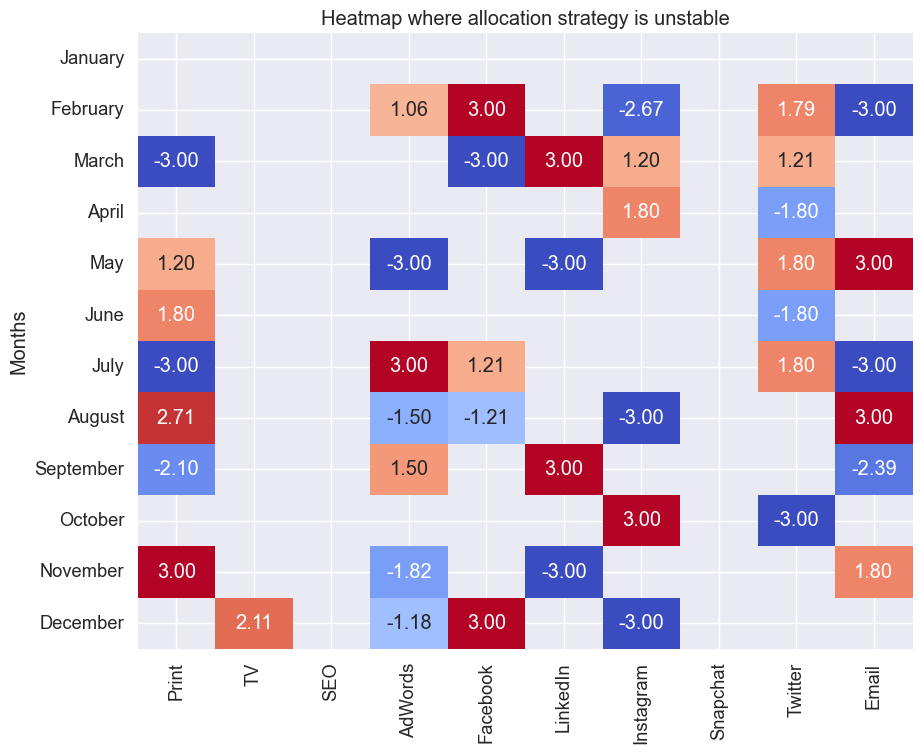

In [48]:
# Create a mask for absolute values greater than 1
mask = abs(df_monthly_change) > 1

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(df_monthly_change, annot=True, fmt=".2f", cmap="coolwarm", mask=~mask, cbar=False)
plt.title("Heatmap where allocation strategy is unstable")
plt.show()

***Summary:***

The allocation strategy is **unstable** as there is a monthly fluctuation of at least one million dollars in at least one platform. In order to achieve stability in monthly allocations, it may be necessary to introduce additional constraints that limit the change in allocation to less than 1 million dollars per month.

In order to implement such stability constraints, a new optimization model would be required, with **120 decision variables** corresponding to each combination of platform and month (10 platforms for 12 months).

For example, the constraints for month-over-month changes could be structured as follows:

- January: The variables a1 to a10 represent allocations for the respective platforms, where subscript 1 corresponds to print, 2 to television, 3 to search engine optimization, and so on with 10 corresponding to email.

- February: Variables b1 to b10 with similar subscripting.

We would define similar sets of variables for March through December as well.

Month-over-month (MoM) stability constraints could then be expressed as:

- February MoM: (b1 - a1) < 1 million, (b2 - a2) < 1 million, ..., (b10 - a10) < 1 million.

- March MoM: (c1 - b1) < 1 million, (c2 - b2) < 1 million, ..., (c10 - b10) < 1 million.

Consequently, these MoM constraints would be applied consistently for each subsequent month, ensuring that allocation changes remain within the specified threshold of one million.

***To achieve a stable allocation, we can consider several methods as follows:***

- **1. Incorporate Monthly Difference Constraints:**
    Directly incorporate constraints that limit the monthly difference between consecutive allocations for each platform.


- **2. Sensitivity Analysis:**
    After determining a solution, perform a sensitivity analysis. This helps to understand how changes in the constraints or coefficients might affect the solution, offering insights into which platforms or months are more flexible or sensitive to variations.


- **3. Hierarchical Linear Programming:**
    If there are multiple objectives (e.g., maximizing reach while also ensuring budget stability), consider solving the LP in a hierarchical manner. Initially, solve for the primary objective. Then, with the solution from the first LP serving as a constraint, solve for the secondary objective.


- **4. Regularization:**
    To ensure a more consistent budget, introduce a regularization term into the objective function. This term would penalize significant month-to-month budget variations.